## Jupyter Notebook 基本
- コードの実行は、セルを選択して、「Shift + Return」です。
- Pythonのバージョン名横の○が●の時は処理中です。

## turi create ライブラリのインストール

In [29]:
!pip install -U turicreate

Requirement already up-to-date: turicreate in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: requests>=2.9.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from turicreate)
Requirement not upgraded as not directly required: pandas>=0.19.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from turicreate)
Requirement not upgraded as not directly required: prettytable==0.7.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from turicreate)
Requirement not upgraded as not directly required: numpy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from turicreate)
Requirement not upgraded as not directly required: mxnet<1.2.0,>=1.1.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from turicreate)
Requirement not upgraded as not directly required: pillow>=3.3.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from turicreate)
Requirement not upgraded as not d

## 教師データ

1. 右から二つ目のアイコンで「Files」ビューを表示します。
1. ローカルPCで分類したい画像の種類ごとにフォルダを作って画像ファイルを入れます。最低１０枚
1. 親フォルダ名はモデルの名前とします。
1. 下記のような形ができたら親フォルダをZip圧縮します。
1. 右の「Files」ビューにフォルダを・ドラッグ&ドロップで入れます。

構造
~~~
- Sushi
    ∟Akami
        ・Akami00a.jpg
        ・maguro.jpg
        ・Sushimaguro.png
          ....

    ∟Toro
        ・TORO.jpg
        ・chuutoro.jpg
        ・toro01.png
          ....

    ∟salmon
        ・shake.jpg
        ・salmon.jpg
        ・sakenigiri.png
          ....
~~~


## アップロードしたファイル名の設定

In [121]:
zipfileName = 'sushi.zip'

### 各種パス設定　変更しなくてOK

In [123]:
sframeFile = "train.sframe"
extPath = "data/temp/ext"
modelFile = 'mymodel.model'
mlmodelFile = 'MyCustomImageClassifier.mlmodel'

In [124]:
import os
import zipfile

## Object Storageとの接続設定の読み込み
1. 下の空のセルを選択する
1. 右のファイル一覧からアップロードしたファイルの下、「Insert to code」を選択し、「Insert Credentials」を選択
1. 「credentials_1」を「credentials」に変更

## データのダウンロードと解凍

In [148]:
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_auth_endpoint=credentials["IBM_AUTH_ENDPOINT"],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials["ENDPOINT"])

try:
    cos.download_file(Bucket=credentials['BUCKET'],Key=zipfileName,Filename=zipfileName)
except Exception as e:
    print(Exception, e)
else:
    print('File Downloaded')

dataPath = os.path.join(extPath,os.path.splitext(zipfileName)[0])

with zipfile.ZipFile(zipfileName) as existing_zip:
     existing_zip.extractall(dataPath)

list = os.listdir(dataPath)

if ".DS_Store" in list :
    list.remove(".DS_Store")
    os.path.remove(dataPath + '/.DS_Store')
if "__MACOSX" in list :
    list.remove("__MACOSX")
    import shutil
    shutil.rmtree(dataPath + '/__MACOSX')

print(list)

File Downloaded
['chuutoro', 'samon', 'ootoro', 'akami']


## turi create

ディレクトリ名でラベルを設定してsframeに保存

In [137]:
import turicreate as tc

def path2label(path):
    for dir in list:
        if dir in path:
            return dir

data = tc.image_analysis.load_images(dataPath, with_path=True)
data['label'] = data['path'].apply(path2label)
data.save(sframeFile)
data.explore()

In [150]:
# 学習用データとテスト用データを分ける
train_data, test_data = data.random_split(0.8)

## モデル作成

In [151]:
# 画像分類モデルを作成
model = tc.image_classifier.create(train_data, target='label')

Performing feature extraction on resized images...
Completed 56/56


Logistic regression:

--------------------------------------------------------

Number of examples          : 56

Number of classes           : 4

Number of feature columns   : 1

Number of unpacked features : 2048

Number of coefficients      : 6147

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | NaN       | 2.607785     | 0.178571          |

| 1         | 7        | 0.000177  | 16.308219    | 0.464286          |

| 2         | 10       | 5.000000  | 24.608263    | 0.750000          |

| 3         | 11       | 5.000000  | 27.206344    | 0.535714          |

| 4         | 13       | 1.000000  | 33.512693    | 0.714286          |

| 5         | 14       | 1.000000  | 36.315454    | 0.803571          |

| 6         | 15       | 1.000000  | 39.598396    | 0.839286          |

| 7         | 16       | 1.000000  | 43.299091    | 1.000000          |

| 8         | 17       | 1.000000  | 46.213015    | 0.982143          |

| 9         | 18       | 1.000000  | 49.998825    | 1.000000          |

| 10        | 19       | 1.000000  | 54.317252    | 1.000000          |

+-----------+----------+-----------+--------------+-------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

In [153]:
# テストデータを使って検証
predictions = model.predict(test_data)

# 評価結果を出力
metrics = model.evaluate(test_data)
print(metrics['accuracy'])

Performing feature extraction on resized images...
Completed 16/16
0.5


In [154]:
# モデルを保存
model.save(modelFile)

# Core ML用モデルを書き出し
model.export_coreml(mlmodelFile)
cos.upload_file(Filename=mlmodelFile,Bucket=credentials['BUCKET'],Key=mlmodelFile)

## テストデータの結果表示

In [158]:
test_data['predictions'] = model.predict(test_data)
print(test_data)

+-------------------------------+--------------------------+----------+-------------+
|              path             |          image           |  label   | predictions |
+-------------------------------+--------------------------+----------+-------------+
| data/temp/ext/sushi/akami/... |  Height: 640 Width: 426  |  akami   |    samon    |
| data/temp/ext/sushi/akami/... |  Height: 225 Width: 225  |  akami   |    ootoro   |
| data/temp/ext/sushi/akami/... |  Height: 168 Width: 300  |  akami   |    samon    |
| data/temp/ext/sushi/akami/... | Height: 1500 Width: 2000 |  akami   |    samon    |
| data/temp/ext/sushi/akami/... |  Height: 255 Width: 340  |  akami   |    ootoro   |
| data/temp/ext/sushi/akami/... |  Height: 480 Width: 480  |  akami   |    akami    |
| data/temp/ext/sushi/chuuto... |  Height: 500 Width: 600  | chuutoro |    samon    |
| data/temp/ext/sushi/ootoro... |  Height: 183 Width: 275  |  ootoro  |    samon    |
| data/temp/ext/sushi/ootoro... |  Height: 225 Width: 

samon
×
正解 akami


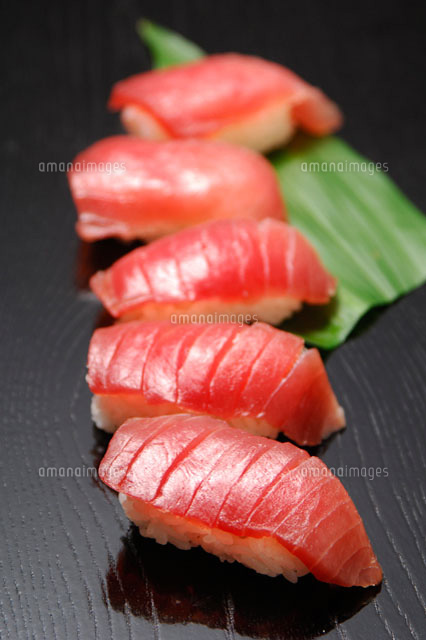

ootoro
×
正解 akami


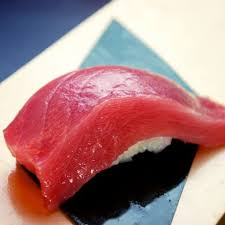

samon
×
正解 akami


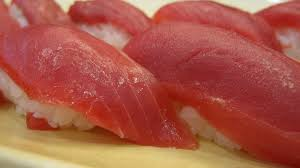

samon
×
正解 akami


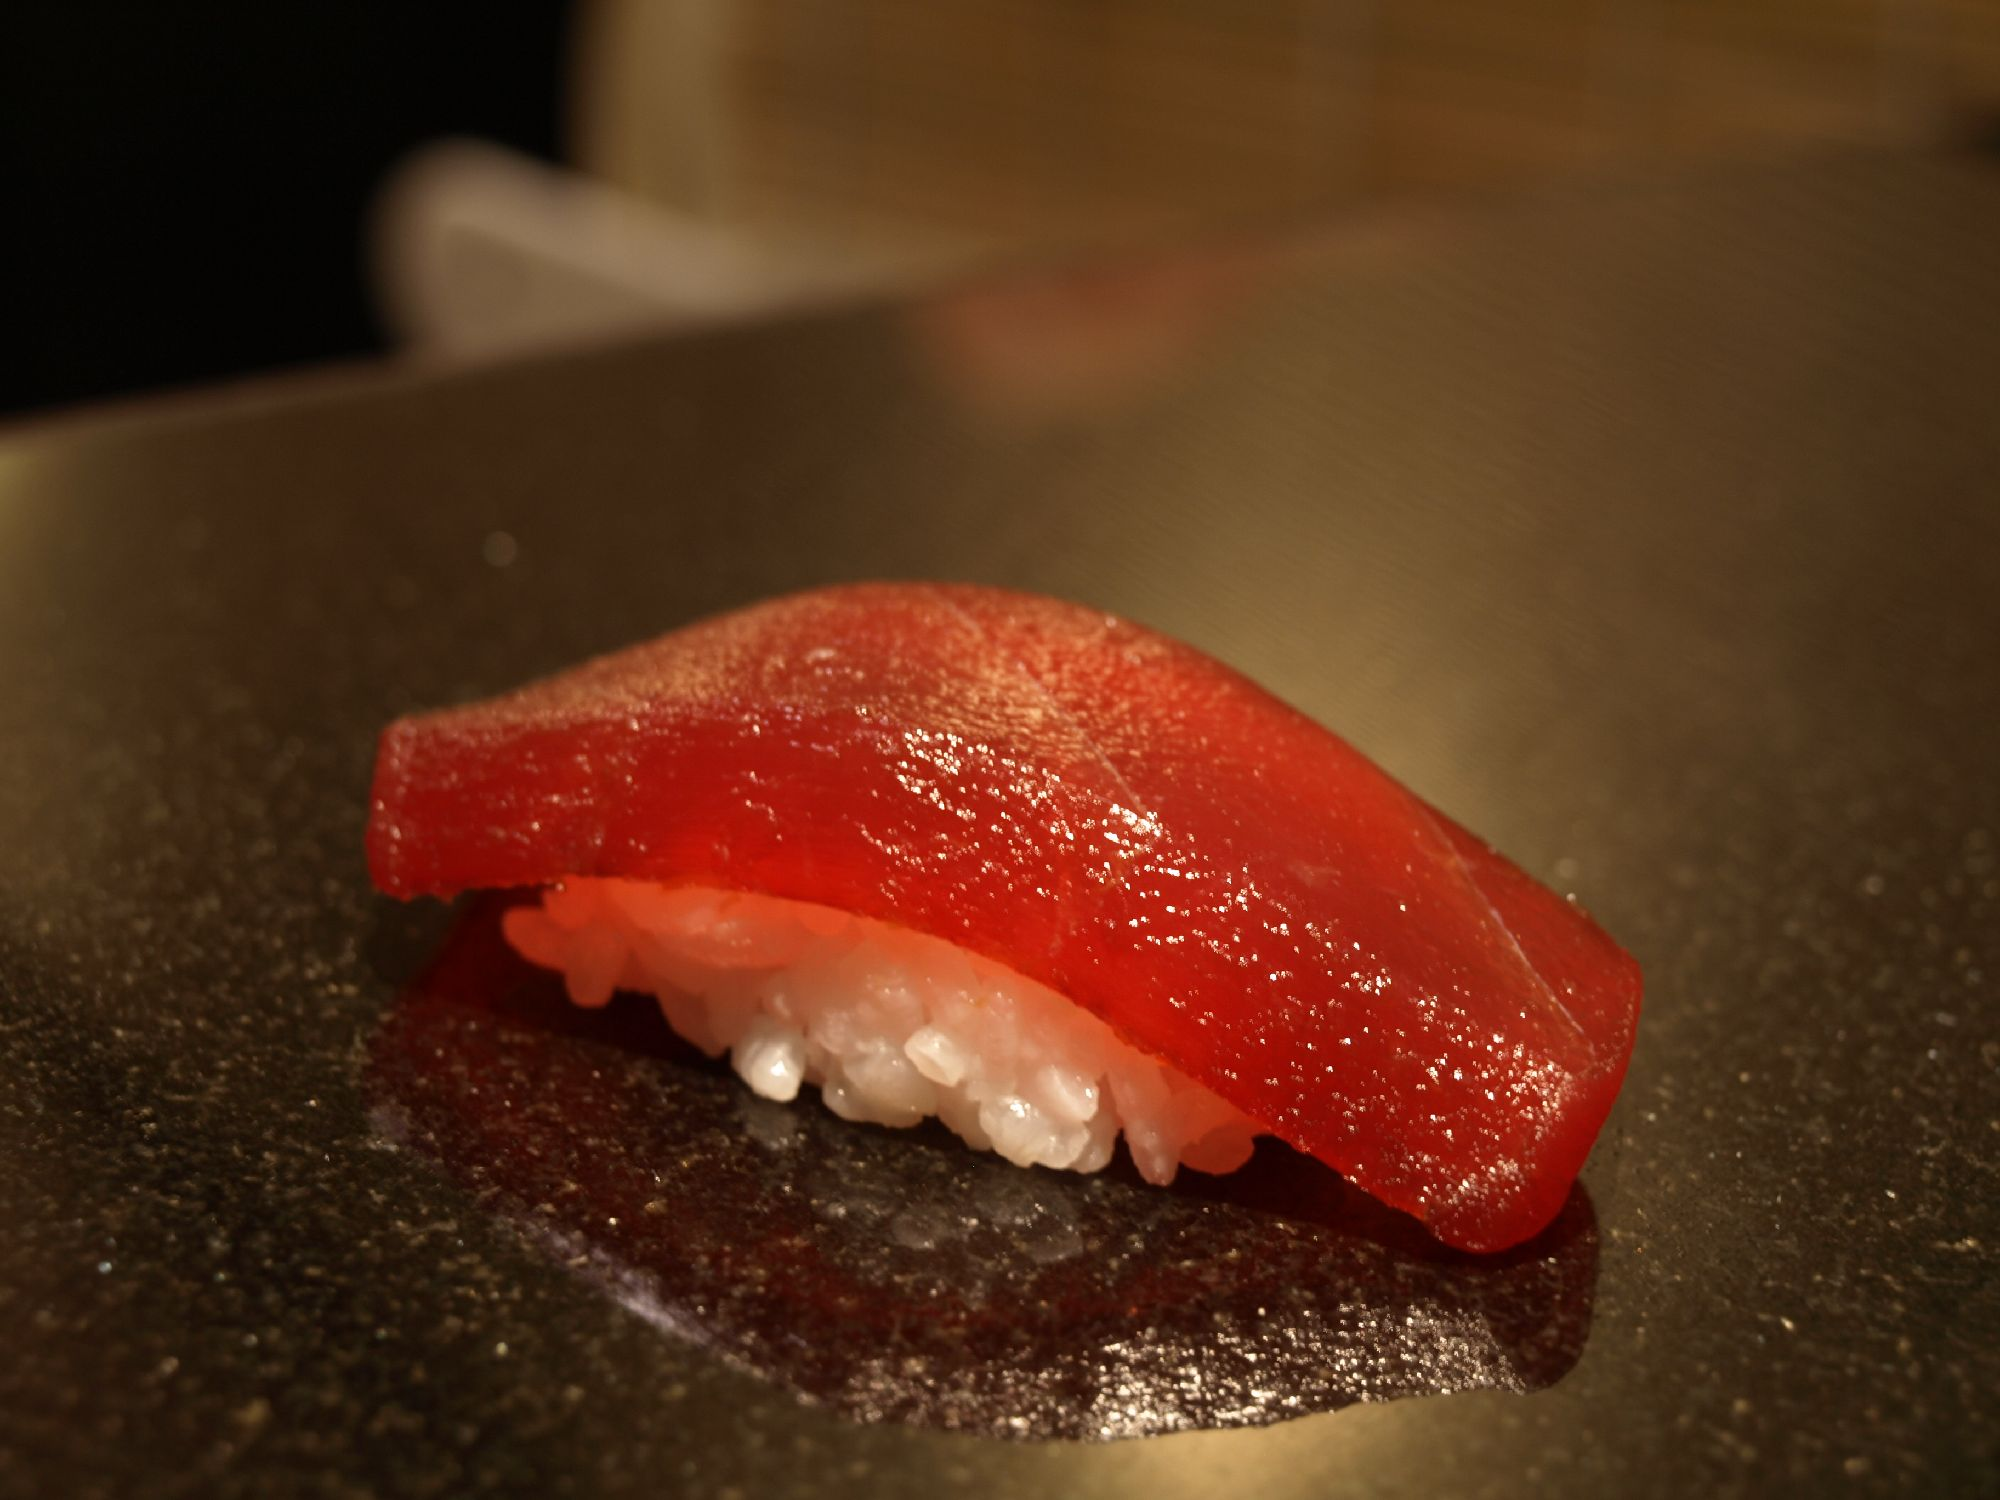

ootoro
×
正解 akami


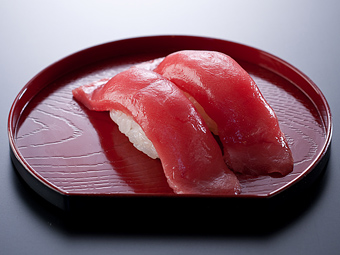

akami
○


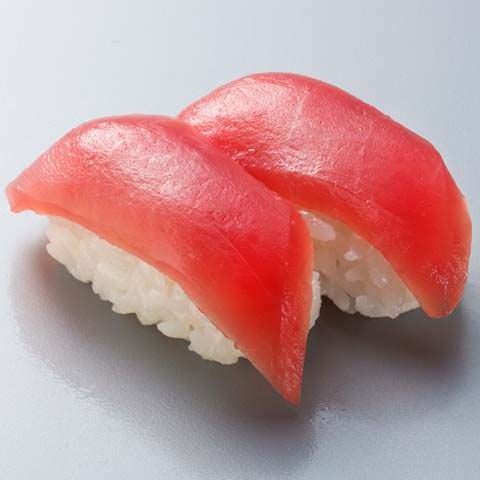

samon
×
正解 chuutoro


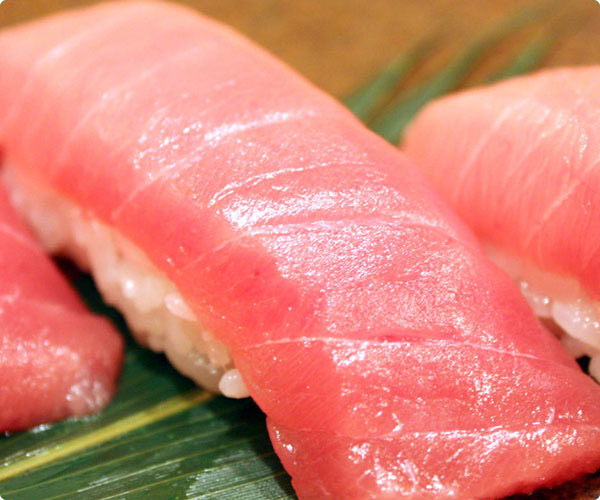

samon
×
正解 ootoro


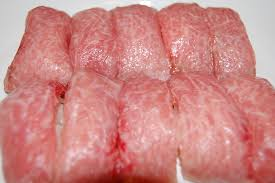

ootoro
○


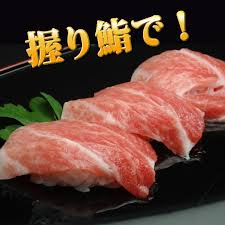

ootoro
○


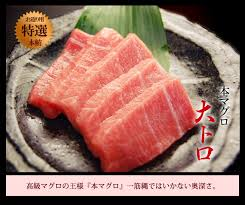

In [160]:
from IPython.display import Image, display_jpeg
for result in test_data[:10]:
    print(result["predictions"])
    if (result["label"] == result["predictions"]) :
        print("○")
    else:
        print("×")
        print('正解',result["label"])
    display(Image(result["path"]))

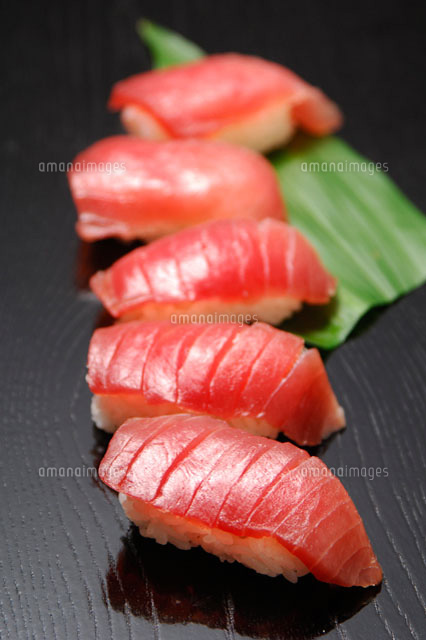

label=akami,predictions=samon


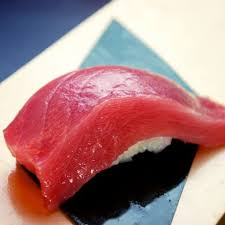

label=akami,predictions=ootoro


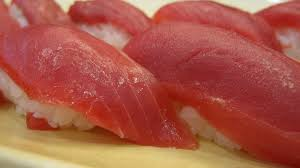

label=akami,predictions=samon


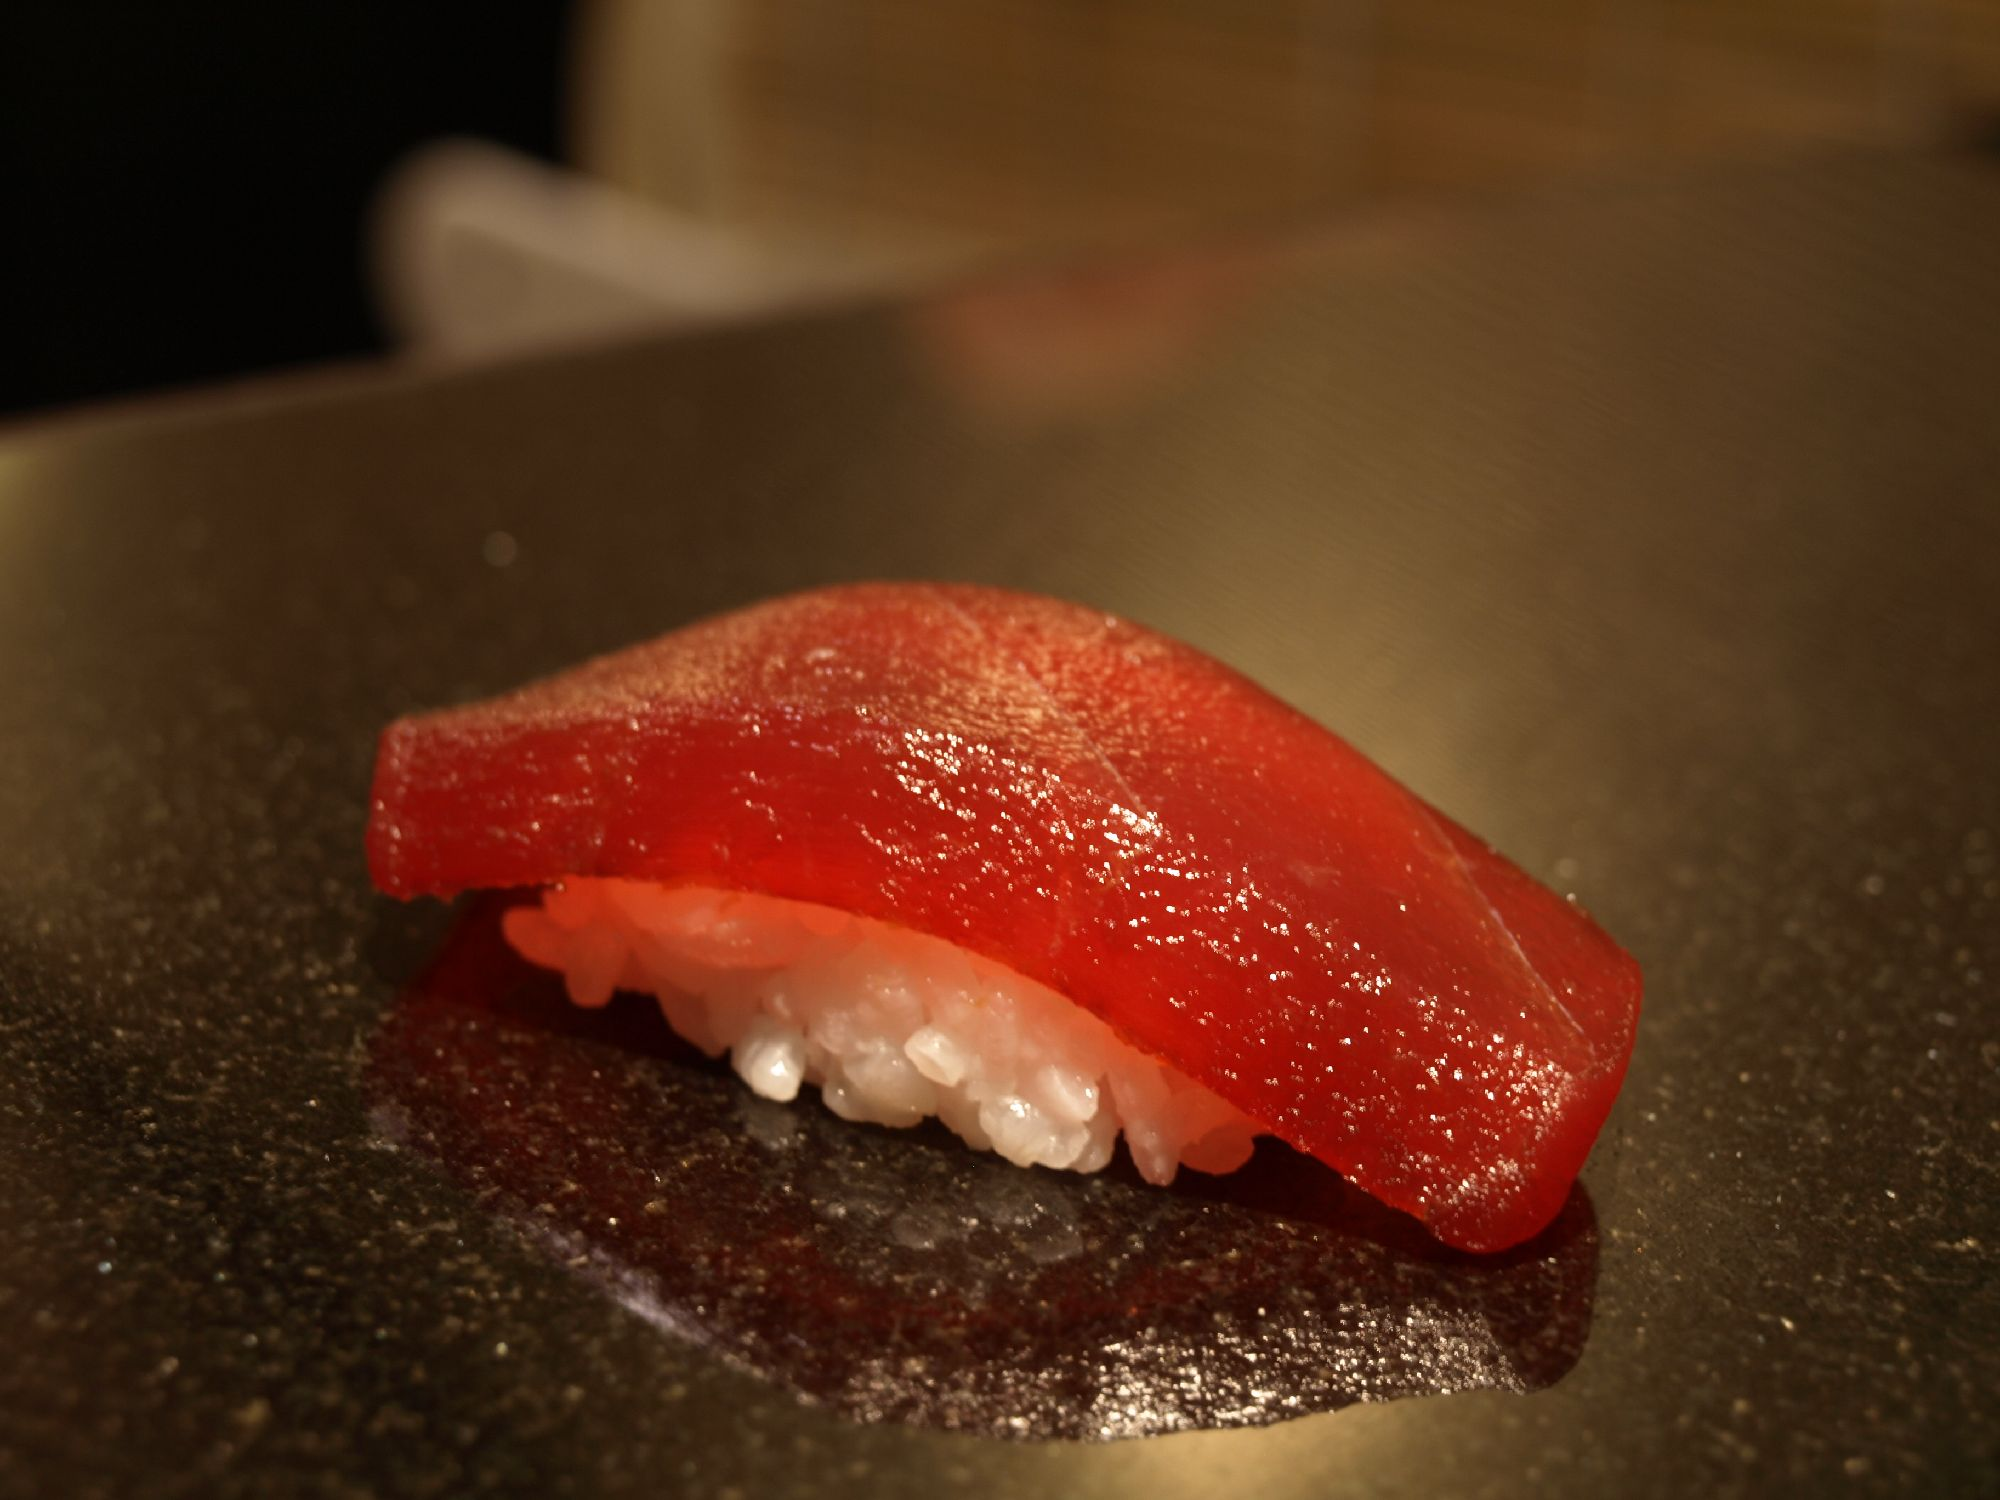

label=akami,predictions=samon


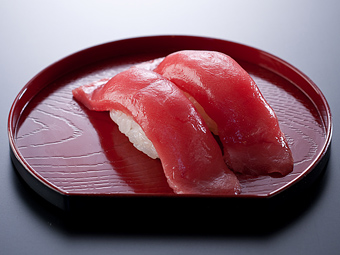

label=akami,predictions=ootoro


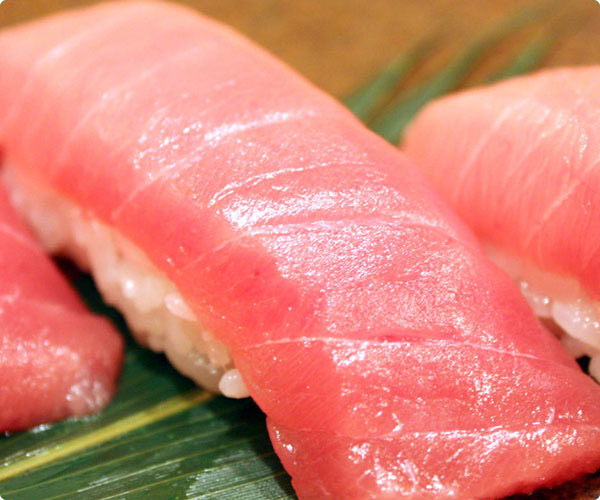

label=chuutoro,predictions=samon


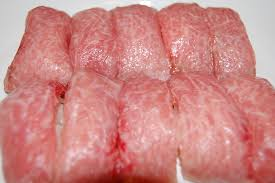

label=ootoro,predictions=samon


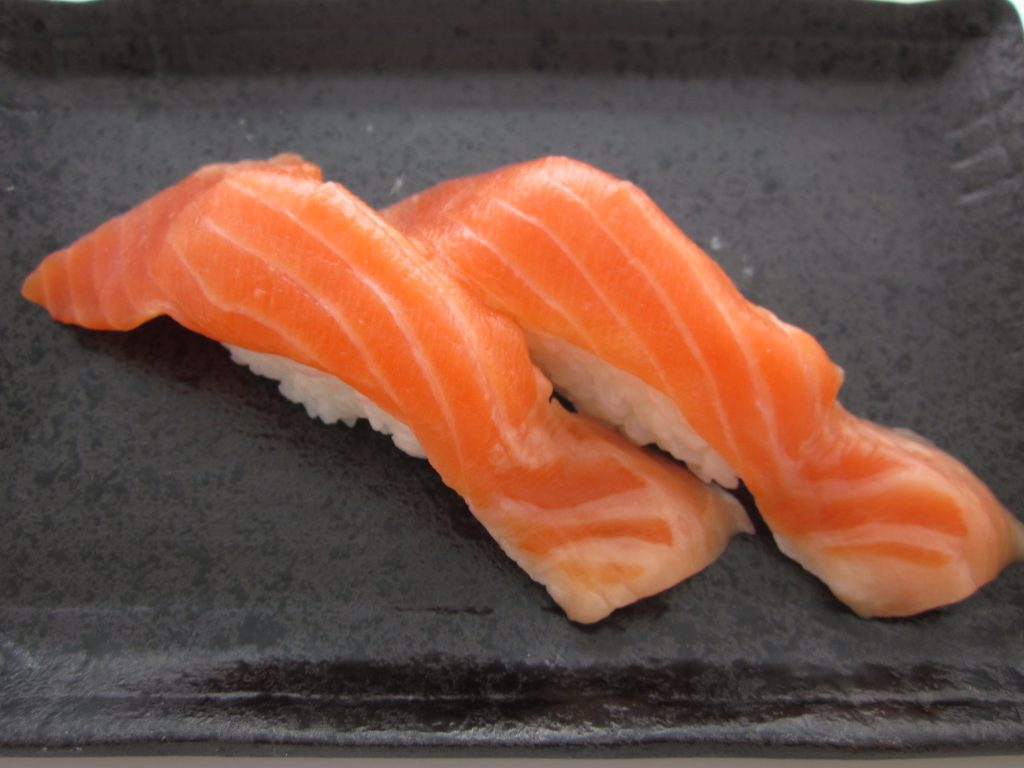

label=samon,predictions=ootoro


In [161]:
results = [result for result in test_data if result["label"] != result["predictions"] ]
for result in results:
    display(Image(result["path"])),print("label=%s,predictions=%s" %(result["label"],result["predictions"]))